# Read basic data 

In [43]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import math 
import matplotlib.style as style
style.use('fivethirtyeight')

from helper import * 
df = pd.read_csv('data/GSPC.csv')

df.shape

(4723, 7)

In [44]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [45]:
df.Open.values

array([1469.25    , 1455.219971, 1399.420044, ..., 2902.540039,
       2877.530029, 2882.51001 ])

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4723 entries, 0 to 4722
Data columns (total 7 columns):
Date         4723 non-null object
Open         4723 non-null float64
High         4723 non-null float64
Low          4723 non-null float64
Close        4723 non-null float64
Adj Close    4723 non-null float64
Volume       4723 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 258.4+ KB


In [47]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4723.000000,4723.000000,4723.000000,4723.000000,4723.000000,4.723000e+03
mean,1490.391028,1498.963225,1481.159353,1490.577815,1490.577815,3.055488e+09
std,497.218669,497.378162,497.080972,497.342663,497.342663,1.504790e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08
25%,1140.525024,1148.054993,1132.520019,1140.554993,1140.554993,1.598750e+09
50%,1331.910034,1340.890015,1324.969971,1331.939941,1331.939941,3.155080e+09
75%,1834.179993,1842.630005,1825.084961,1834.784973,1834.784973,3.917190e+09
max,2936.760010,2940.909912,2927.110107,2930.750000,2930.750000,1.145623e+10


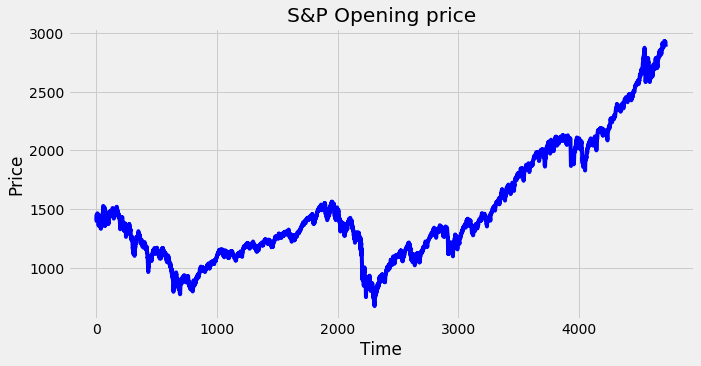

In [48]:
make_plot(df.Close.values, title= 'S&P Opening price', xlab='Time', ylab='Price', colour='blue')

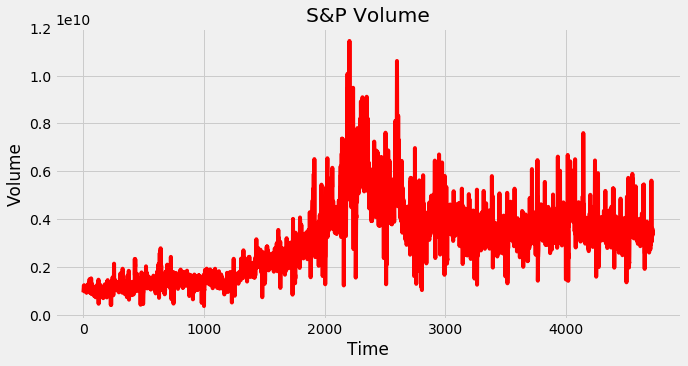

In [49]:
make_plot(df.Volume.values, title= 'S&P Volume', xlab='Time', ylab='Volume', colour='red')

# Data manipulation

In [50]:
# # function for min-max normalization of stock
# def normalize_data(data):
#     min_max_scaler = MinMaxScaler()
#     data = min_max_scaler.fit_transform(data.values.reshape(-1,1))
#     return data

In [59]:
dat = normalize_data(df.Close)

In [51]:
# df = normalize_data(df.Close.values)

# # df.drop(['Volume'],1,inplace=True)
# # df.drop(['Date'],1,inplace=True)
# # remove adj close
# # df = df.drop('Adj Close', axis=1)
# df

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [57]:
seq_len = 20

In [68]:
len(dat)

4723

In [74]:
x_train, y_train, x_valid, y_valid = load_data(inputdata=dat, seq_len = seq_len, val_percent = 0.1)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)

x_train.shape =  (4233, 19, 1)
y_train.shape =  (4233, 1)
x_valid.shape =  (470, 19, 1)
y_valid.shape =  (470, 1)


# Modeling a RNN with (LSTM / GRU cells)

In [248]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
# random array of train set
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

perm_array.shape


# function to get the next batch data
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]
    

    
# x_train, y_train = get_next_batch(batch_size=50)

# x_train.shape
# y_train.shape


In [83]:
# parameters
n_steps = seq_len-1 
n_inputs = 1
n_neurons = 200 
n_outputs = 1
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 10 
train_set_size = x_train.shape[0]
test_set_size = x_valid.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
# tf.nn.elu are exponential linear units
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)


stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [85]:
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    
    for i in range(n_epochs):
        sess.run(training_op, feed_dict={X: x_train, y:y_train})
        
        mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
        mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
        print('Iter: ', i, 'MSE_Train = %.6f' % (mse_train), 'MSE_Validation = %.6f' % (mse_valid))
        
        y_train_pred = sess.run(outputs, feed_dict={X: x_train})
        y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})

Iter:  0 MSE_Train = 0.045140 MSE_Validation = 0.318682
Iter:  1 MSE_Train = 0.003187 MSE_Validation = 0.043693
Iter:  2 MSE_Train = 0.031882 MSE_Validation = 0.051633
Iter:  3 MSE_Train = 0.015892 MSE_Validation = 0.013917
Iter:  4 MSE_Train = 0.001840 MSE_Validation = 0.007593
Iter:  5 MSE_Train = 0.004646 MSE_Validation = 0.055986
Iter:  6 MSE_Train = 0.011131 MSE_Validation = 0.101025
Iter:  7 MSE_Train = 0.013799 MSE_Validation = 0.117033
Iter:  8 MSE_Train = 0.012067 MSE_Validation = 0.106230
Iter:  9 MSE_Train = 0.007883 MSE_Validation = 0.079226


In [250]:
# # run graph
# with tf.Session() as sess: 
#     sess.run(tf.global_variables_initializer())
    
#     for iteration in range(int(n_epochs*train_set_size/batch_size)):
#         x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
#         sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 

#         if iteration % int(5*train_set_size/batch_size) == 0:
#             mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
#             mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
#             print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
#                 iteration*batch_size/train_set_size, mse_train, mse_valid))

#     y_train_pred = sess.run(outputs, feed_dict={X: x_train})
#     y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})

0.00 epochs: MSE train/valid = 0.030295/0.147841
5.00 epochs: MSE train/valid = 0.000159/0.000264
9.99 epochs: MSE train/valid = 0.000116/0.000220
14.99 epochs: MSE train/valid = 0.000083/0.000130
19.98 epochs: MSE train/valid = 0.000065/0.000097
24.98 epochs: MSE train/valid = 0.000052/0.000081
29.98 epochs: MSE train/valid = 0.000062/0.000137
34.97 epochs: MSE train/valid = 0.000034/0.000050
39.97 epochs: MSE train/valid = 0.000031/0.000043
44.96 epochs: MSE train/valid = 0.000027/0.000048
49.96 epochs: MSE train/valid = 0.000030/0.000067
54.96 epochs: MSE train/valid = 0.000024/0.000048
59.95 epochs: MSE train/valid = 0.000024/0.000047
64.95 epochs: MSE train/valid = 0.000027/0.000066
69.94 epochs: MSE train/valid = 0.000024/0.000050
74.94 epochs: MSE train/valid = 0.000021/0.000038
79.94 epochs: MSE train/valid = 0.000025/0.000043
84.93 epochs: MSE train/valid = 0.000022/0.000044
89.93 epochs: MSE train/valid = 0.000039/0.000181
94.92 epochs: MSE train/valid = 0.000026/0.000071
99.

# Predictions

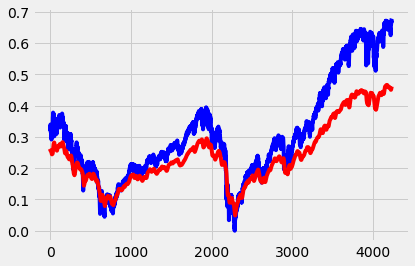

In [88]:
plt.plot(y_train, color='blue', label='Train')
plt.plot(y_train_pred, color='red', label='Train')

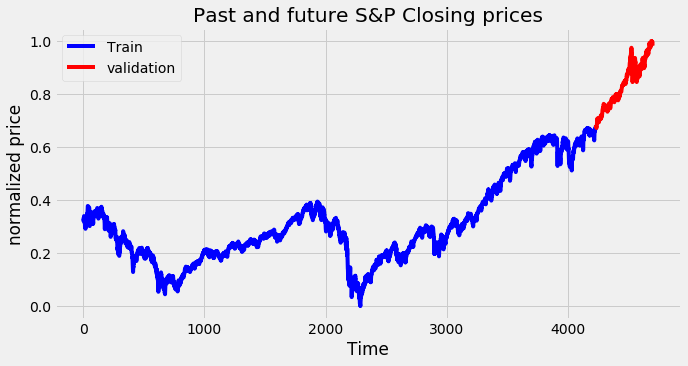

In [92]:
plt.figure(figsize=(10, 5));
plt.plot(np.arange(y_train.shape[0]), y_train, color='blue', label='Train')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid, color='red', label='validation')

plt.title('Past and future S&P Closing prices')
plt.xlabel('Time')
plt.ylabel('normalized price')
plt.legend(loc='best');

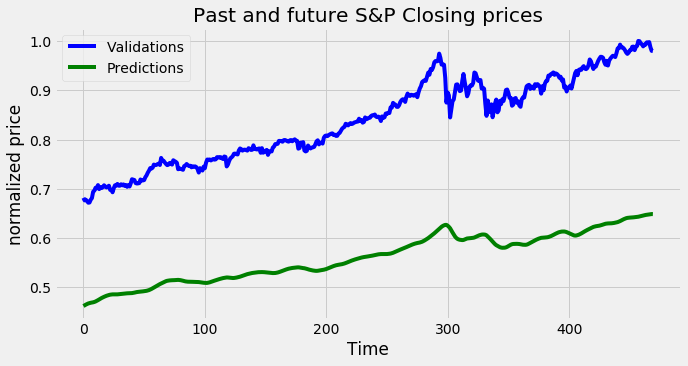

In [97]:
plt.figure(figsize=(10, 5));
plt.plot(np.arange(y_valid.shape[0]), y_valid, color='blue', label='Validations')
plt.plot(np.arange(y_valid_pred.shape[0]), y_valid_pred, color='green', label='Predictions')
# plt.plot(np.arange(y_valid_pred.shape[0], y_valid.shape[0]), y_valid, color='red', label='validation')

plt.title('Past and future S&P Closing prices')
plt.xlabel('Time')
plt.ylabel('normalized price')
plt.legend(loc='best');